In [1]:
import numpy as np
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import time
import scipy
from scipy.spatial import distance_matrix
from matplotlib import animation
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
def roots_function(mat_x_y, bound_values):
    min_mat = bound_values.T[0, :]
    max_mat = bound_values.T[1,:]

    mat_x_y_denorm= mat_x_y * (max_mat - min_mat) + min_mat


    x = mat_x_y_denorm[:, 0]
    y = mat_x_y_denorm[:, 1]
    z = x + 1j*y
    g = 1 / (1 + np.abs(z**6 - 1))
    return g

In [3]:
def schaffer_function(mat_x_y, bound_values):
    min_mat = bound_values.T[0, :]
    max_mat = bound_values.T[1,:]

    mat_x_y_denorm= mat_x_y * (max_mat - min_mat) + min_mat


    x = mat_x_y_denorm[:, 0]
    y = mat_x_y_denorm[:, 1]
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

In [4]:
def multi_function(mat_x_y, bound_values):
    min_mat = bound_values.T[0, :]
    max_mat = bound_values.T[1,:]

    mat_x_y_denorm= mat_x_y * (max_mat - min_mat) + min_mat


    x = mat_x_y_denorm[:, 0]
    y = mat_x_y_denorm[:, 1]

    z = x*np.sin(4*np.pi*x) - y*np.sin(4*np.pi*y-np.pi)
    return z

100%|██████████| 10/10 [00:00<00:00, 421.80it/s]

[False False False False False False]
[]
[False False False False False False False False False False False False
 False False False False False False]
[]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
[]
[False False False False False False False False False]
[]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
[]
[False False False False False False False False False False False False]
[]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False 

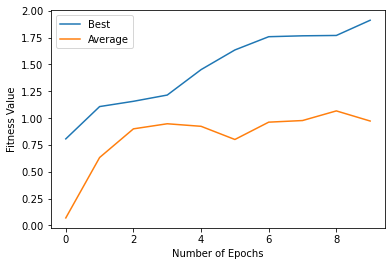

In [79]:
class OptAiNet():
    def __init__(self,
                 num_epochs:int,
                 pop_size:int,
                 Nc:int,
                 chrom_length:int,
                 value_ranges:list,
                 fitness_func, # Function Type,
                 beta=100,
                 clone_threshold = 0.01,
                 supression_threshold=0.2,
                 newcomers_percentage = 0.4,
                 seed=42,
                 eval_every=100,
                 verbose = 0,
                 maintain_history = False
                ):
        
        self.num_epochs = num_epochs
        self.pop_size = pop_size
        self.value_ranges = np.array(value_ranges)
        self.fitness_func = fitness_func
        self.chrom_length = chrom_length
        self.Nc = Nc
        self.beta = beta
        self.clone_threshold = clone_threshold
        self.supression_threshold = supression_threshold
        self.newcomers_percentage = newcomers_percentage

        self.f_pop_avg_previous = 0
        self.continue_clone = True

        self.seed = seed    
        self.best_ind_list = np.zeros(self.num_epochs)
        self.avg_ind_list = np.zeros(self.num_epochs)
        self.eval_every = eval_every
        self.verbose = verbose
        np.random.seed(seed=seed)


        # Problem in max_fitness inicialization due to high incidence of zeros in rocket fitness
        self.max_fitness = 0.1
        self.min_fitness = 0

        self.best_solution_fitness = 0
        self.best_solution = 0

        self.maintain_history = maintain_history
        self.memory_cell_history = []
        self.clone_history = []

        self.min_mat = self.value_ranges.T[0, :]
        self.max_mat = self.value_ranges.T[1,:]
        self.previous_memory_cells_quantity = 0
        self.has_converged = False


        # self.init_pop()
        # self.fitness_evaluation()
        # self.clone()
        # self.mutation()
        # self.fitness_evaluation()
        # self.evaluation()
        # #self.supress_cells()
        # self.supress_cells_2()
        # #self.add_newcomers()


    
    def init_pop(self):
        self.pop = np.random.rand(self.pop_size, self.chrom_length)
        self.memory_cells = self.pop.copy()
        #self.min_mat = self.value_ranges.T[0, :]
        #self.max_mat = self.value_ranges.T[1,:]
        #self.pop = self.pop * (self.max_mat - self.min_mat) + self.min_mat
        #self.f_pop = self.fitness_func(self.pop)
    
    def fitness_evaluation(self):
        self.f_pop = self.fitness_func(self.pop, self.value_ranges)
        self.curr_f_max = self.f_pop.max()
        self.curr_f_min = self.f_pop.min()

        self.max_fitness = self.curr_f_max
        self.min_fitness = self.curr_f_min
        if self.max_fitness == 0:
            self.max_fitness = 0.01

        # if self.max_fitness < self.curr_f_max:
        #     self.max_fitness = self.curr_f_max
        # if self.min_fitness > self.curr_f_min:
        #     self.min_fitness = self.curr_f_min

        self.f_pop_norm = (self.f_pop - self.min_fitness)/(self.max_fitness - self.min_fitness)
        curr_max_fitness = self.f_pop.max()
        if self.best_solution_fitness < curr_max_fitness:
            self.best_solution = self.pop[self.f_pop.argmax()]
            self.best_solution_fitness = curr_max_fitness

        return
    
    def clone(self):
        self.pop = np.repeat(self.pop, repeats=self.Nc + 1, axis=0)
        self.f_pop_norm = np.repeat(self.f_pop_norm, repeats=self.Nc + 1, axis=0)
        memory_denorm = self.memory_cells * (self.max_mat - self.min_mat) + self.min_mat
        self.memory_cell_history.append(memory_denorm)
        clone_denorm = self.pop * (self.max_mat - self.min_mat) + self.min_mat
        self.clone_history.append(clone_denorm)


    def mutation(self):
        self.alpha = (1/self.beta) * np.exp(-self.f_pop_norm)
        self.random_mutation = np.random.normal(0, 1, size=self.pop.shape[0] * self.pop.shape[1])
        self.random_mutation = self.random_mutation.reshape(self.pop.shape[0], self.pop.shape[1])
        mask = np.zeros(self.random_mutation.shape[0], dtype=bool)
        mask[::self.Nc + 1] = True
        self.random_mutation[mask,:] = 0
        self.alpha = np.repeat(self.alpha, self.chrom_length)

        self.alpha = self.alpha.reshape(self.random_mutation.shape)

        self.pop = self.pop + self.alpha * self.random_mutation
        mask = self.pop > 1

        # self.pop[mask] = 1
        # print(mask)
        # mask = self.pop < 0
        # print(mask)
        # self.pop[mask] = 0
        rows_to_delete = np.any(self.pop > 1, axis=1)
        self.pop = self.pop[~rows_to_delete]
        rows_to_delete = np.any(self.pop < 0, axis=1)
        self.pop = self.pop[~rows_to_delete]

        # Still needs to add a way to invalidate a individual in a positsion outside of the searhc spacie

    def evaluation(self):
        self.f_pop_avg = self.f_pop.mean()
        mean_error = np.abs(self.f_pop_avg - self.f_pop_avg_previous)
        if  mean_error < self.clone_threshold:
            self.continue_clone = False
            #if self.maintain_history:
                #clone_denorm = self.pop * (self.max_mat - self.min_mat) + self.min_mat
                #self.clone_history.append(clone_denorm)
        else:
            self.continue_clone = True
        self.f_pop_avg_previous = self.f_pop_avg
    
    def supress_cells(self):
        print(self.pop)
        distances = distance_matrix(self.pop, self.pop) 
        print(distances)       
        f_pop_matrix = np.tile(self.f_pop, (distances.shape[0], 1)) 
        print(f_pop_matrix)
        masked_f = f_pop_matrix * (distances<self.supression_threshold)
        best_indices = np.where(masked_f == masked_f.max(axis=1).T)[1]
        best_indices = np.unique(best_indices)
        self.pop = self.pop[best_indices]
        self.f_pop = self.f_pop[best_indices]
        self.best_ind = self.pop.copy()
        self.best_fits = self.f_pop.copy()
        self.memory_cells = self.pop.copy()

    def supress_cells_2(self):
        #print(self.pop)
        #print(self.f_pop)
        #distances = distance_matrix(self.pop, self.pop) 
        #print(distances)

        i = 0
        j = 0
        inter_count = 0
        # print(self.pop)
        # print("###")
        # print(self.f_pop)
        # print("###")
        while True:
            #if inter_count > 5:
            #    return
            #inter_count += 1
            if i == j:
                j+=1
            if j >= self.pop.shape[0]:
                i = i + 1 
                j = 0
            if i >= self.pop.shape[0]:
                self.best_ind = self.pop.copy()
                self.best_fits = self.f_pop.copy()
                self.memory_cells = self.pop.copy()
                break

            dist = np.linalg.norm(self.pop[i] - self.pop[j])
            is_near = dist < self.supression_threshold
            if is_near:
                if self.f_pop[i] > self.f_pop[j]:
                    self.f_pop = np.delete(self.f_pop, j)
                    self.pop = np.delete(self.pop, j, 0)
                    #j+=1
                else:
                    self.f_pop = np.delete(self.f_pop, i)
                    self.pop = np.delete(self.pop, i, 0)
                    #i+=1
            else:
                j+=1

        # Check if algorithm has converged
        curr_memory_cells_quantity = self.pop.shape[0]
        if self.previous_memory_cells_quantity == curr_memory_cells_quantity:
            self.has_converged=True
        else:
            self.previous_memory_cells_quantity = curr_memory_cells_quantity
        # print(self.pop)
        # print("###")
        # print(self.f_pop)
                
    def add_newcomers(self):
        n_new_ind = int(len(self.pop) * self.newcomers_percentage)
        if n_new_ind == 0:
            n_new_ind = 1
        newcomers = np.random.rand(n_new_ind, self.chrom_length)
        #newcomers = newcomers * (self.max_mat - self.min_mat) + self.min_mat
        self.pop = np.append(self.pop, newcomers, axis=0)

    def callback(self):
        max_val = np.max(self.f_pop)
        mean_val = np.mean(self.f_pop)
        self.best_ind_list[self.curr_epoch] = max_val
        self.avg_ind_list[self.curr_epoch] = mean_val
        if (self.curr_epoch % self.eval_every == 0) and self.verbose != 0 :
            print(f"Epoch {self.curr_epoch}: Best: {max_val}, Average: {mean_val}")

    def fit(self):
        start_time = time.time()
        self.init_pop()
        self.fitness_evaluation()
        for epoch in tqdm(range(self.num_epochs)):
            self.curr_epoch = epoch
            ###
            ###
            while self.continue_clone:
                self.clone()
                self.mutation()
                self.fitness_evaluation()
                self.evaluation()
            self.continue_clone = True
            self.f_pop_avg_previous = 0
            self.supress_cells_2()
            self.callback()
            # print(self.previous_memory_cells_quantity)
            # if self.has_converged:
            #     print(f"Algorthm has converged in generation {epoch}")
            #     break
            self.add_newcomers()
            self.fitness_evaluation()
        print("--- %s seconds ---" % (time.time() - start_time))
        return self.best_ind

    def plot(self):
        plt.plot(self.best_ind_list, label="Best")
        plt.plot(self.avg_ind_list, label="Average")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Fitness Value")
        plt.legend()
        plt.show()



opt_ai_net = OptAiNet( 
                num_epochs=10,
                pop_size=2,
                Nc=2,
                chrom_length=2,
                clone_threshold=0.1,
                supression_threshold=0.2,
                newcomers_percentage=0.4,
                beta=100,
                value_ranges=[(-1,2), (-1,2)],
                fitness_func=multi_function,
                maintain_history=True
            )

best_solutions = opt_ai_net.fit()
opt_ai_net.plot()

In [74]:
best_solutions.max(axis=1)

array([0.12172133, 0.87630616, 0.87631876, 0.87628767, 0.87629261,
       0.54494682, 0.87597052, 0.54502107, 0.71044425, 0.34501272,
       0.71019029, 0.87628807, 0.54497393, 0.32173465, 0.99999108,
       0.71026424, 0.87600639, 0.9999984 , 0.69928897, 0.69910331,
       0.52283135, 0.52139699])

[1.25998588 2.25693703 3.25388765 2.25693684 2.25693736 1.25998529
 1.64145525 1.25998527 1.12762461 0.64491483 2.25560312 2.25693709
 1.25998603 0.64472046 1.12712877 1.12767413 1.64168998 1.12640235
 1.0468103  1.04551873 0.44844859 0.42315298]


Text(0.5, 0, 'z')

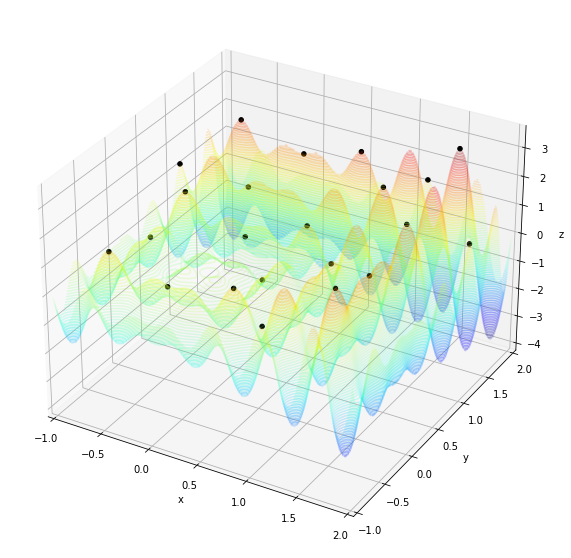

In [75]:
def schaffer_function_plot(x,y):
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

def roots_function_plot(x,y):
    z = x + 1j*y
    g = 1 / (1 + np.abs(z**6 - 1))
    return g

def multi_function_plot(x,y):
    z = x*np.sin(4*np.pi*x) - y*np.sin(4*np.pi*y-np.pi)
    return z

value_ranges = np.array([[-1,2], [-1,2]])
min_mat = value_ranges.T[0, :]
max_mat = value_ranges.T[1,:]
best_solutions_denorm = best_solutions * (max_mat - min_mat) + min_mat


x_data = best_solutions_denorm[:, 0]
y_data = best_solutions_denorm[:, 1]


#z_data = roots_function_plot(x_data, y_data)
z_data = multi_function_plot(x_data, y_data)

print(z_data)


x = np.linspace(-1, 2, 100)
y = np.linspace(-1, 2, 100)

X, Y = np.meshgrid(x, y)
#Z = roots_function_plot(X, Y)
Z = multi_function_plot(X, Y)

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z,100,cmap='jet', alpha=0.2)
ax.scatter3D(x_data, y_data, z_data, c='k', alpha=1)
ax.set_xlim3d(-1,2)
ax.set_ylim3d(-1,2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


MovieWriter imagemagick unavailable; using Pillow instead.


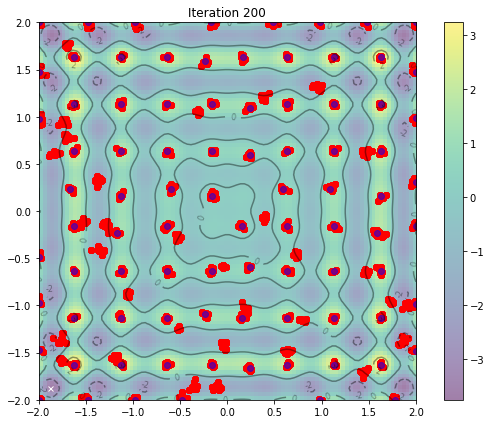

In [30]:
# Compute and plot the function in 3D within [0,5]x[0,5]
x, y = np.array(np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100)))
z = multi_function_plot(x, y)
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]

memory_cells = opt_ai_net.memory_cell_history
clones = opt_ai_net.clone_history

fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 2, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
clone_plot = ax.scatter(clones[0][:,0],clones[0][:,1], marker='o', color='red', alpha=0.5)
memory_plot = ax.scatter(memory_cells[0][:,0],memory_cells[0][:,1], marker='o', color='blue', alpha=0.5)


ax.set_xlim([-2,2])
ax.set_ylim([-2,2])


def animate(i):
    "Steps of PSO: algorithm update and show in plot"
    title = 'Iteration {:02d}'.format(i)
    ax.set_title(title)
    clone_plot.set_offsets(clones[i])
    memory_plot.set_offsets(memory_cells[i])

    return ax, memory_plot, clone_plot

anim = FuncAnimation(fig, animate, frames=list(range(1,len(clones))), interval=200, blit=False, repeat=True)
anim.save("optainet.gif", dpi=120, writer="imagemagick")

# #print("PSO found best solution at f({})={}".format(gbest, gbest_obj))
# print("Global optimal at f({})={}".format([x_min,y_min], schaffer_function_plot(x_min,y_min)))
# HTML(anim.to_jshtml())


In [35]:
opt_ai_net.pop[opt_ai_net.pop < 0.1]

array([9.27926305e-02, 9.27188557e-02, 9.27903317e-02, 9.27672581e-02,
       9.27585244e-02, 9.28264549e-02, 9.27670192e-02, 9.27104316e-02,
       9.27450073e-02, 9.27787625e-02, 9.27766667e-02, 9.28028601e-02,
       9.27612172e-02, 9.27546442e-02, 3.26329870e-06, 1.75225453e-04,
       2.86431032e-05, 1.58211912e-04, 6.81418074e-05, 8.41513877e-05,
       8.41895775e-02, 2.97816279e-04, 1.56696297e-04, 1.00916002e-04,
       8.29590915e-02, 1.34095877e-05, 5.55028581e-04, 1.04676181e-04,
       2.25812934e-04, 2.54531725e-02, 1.59778642e-02, 5.47095231e-02,
       6.62690899e-04, 4.25400041e-02, 9.49970182e-02, 9.21161715e-04,
       1.38044415e-02, 2.09288028e-02, 1.85241856e-02, 1.51261415e-02,
       9.32789850e-02, 1.19920163e-02])